## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Get a Census API key and replace it in the cell below

In [4]:
%%R 

census_api_key("45b5229bf84408d59ed16d2ffea12cc3185384b7") # <- Insert your Census API key here

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Once you've found the variable or variables you want, you can plug them into this code under `variables`. 

In [5]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/

# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",     # population
                        median_income_born_in_state = "B06011_002",  
                        median_income="B06011_001",
                        median_income_born_out_of_state= "B06011_003",
                        median_income_native_born_outsideof_US="B06011_004",
                        median_income_for_foreign_born="B06011_005"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

write.csv(nyc_census_data, file = "nyc_census_data.csv")

nyc_census_data


  |======================================================================| 100%
Simple feature collection with 13962 features and 5 fields (with 6 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                      NAME
1  36081014700 Census Tract 147, Queens County, New York
2  36081014700 Census Tract 147, Queens County, New York
3  36081014700 Census Tract 147, Queens County, New York
4  36081014700 Census Tract 147, Queens County, New York
5  36081014700 Census Tract 147, Queens County, New York
6  36081014700 Census Tract 147, Queens County, New York
7  36047058400  Census Tract 584, Kings County, New York
8  36047058400  Census Tract 584, Kings County, New York
9  36047058400  Census Tract 584, Kings County, New York
10 36047058400  Census Tract 584, Kings County, New York
                                 variable esti

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [6]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  # pivot from wide to long
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

write.csv(nyc_census_data, file = "nyc_census_data_wide.csv")

nyc_census_data

Simple feature collection with 2327 features and 14 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 15
   GEOID       NAME                                 geometry population_estimate
   <chr>       <chr>                      <MULTIPOLYGON [°]>               <dbl>
 1 36081014700 Census Tract 147, … (((-73.9137 40.76548, -7…                2863
 2 36047058400 Census Tract 584, … (((-73.96103 40.59616, -…                3655
 3 36061006900 Census Tract 69, N… (((-74.02064 40.73039, -…                2450
 4 36047073000 Census Tract 730, … (((-73.93345 40.6257, -7…                2676
 5 36047100400 Census Tract 1004,… (((-73.90735 40.63083, -…                3004
 6 36047055700 Census Tract 557, … (((-73.96279 40.72256, -…                1834
 7 36005022101 Census Tract 221.0… (((-73.92012 40.83759, -…                4030
 8 36081047000 Census 

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

In this example, we create a column called `borough` by extracting the borough from the `NAME` column.

_(hint, I used GitHub Copilot -- a tool similar to ChatGPT -- to do this...see my prompt in the comments)_

In [7]:
%%R 

# Extract borough name from NAME by splitting strings like 
# "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
    ) 

nyc_census_data

Simple feature collection with 2327 features and 15 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 16
   GEOID       NAME                                 geometry population_estimate
 * <chr>       <chr>                      <MULTIPOLYGON [°]>               <dbl>
 1 36081014700 Census Tract 147, … (((-73.9137 40.76548, -7…                2863
 2 36047058400 Census Tract 584, … (((-73.96103 40.59616, -…                3655
 3 36061006900 Census Tract 69, N… (((-74.02064 40.73039, -…                2450
 4 36047073000 Census Tract 730, … (((-73.93345 40.6257, -7…                2676
 5 36047100400 Census Tract 1004,… (((-73.90735 40.63083, -…                3004
 6 36047055700 Census Tract 557, … (((-73.96279 40.72256, -…                1834
 7 36005022101 Census Tract 221.0… (((-73.92012 40.83759, -…                4030
 8 36081047000 Census 

In [10]:
%%R
nyc_census_data <- nyc_census_data %>%
  mutate(
    income_diff_instate_outstate = median_income_born_in_state_estimate - median_income_born_out_of_state_estimate
   
  )

nyc_census_data

Simple feature collection with 2327 features and 16 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 17
   GEOID       NAME                                 geometry population_estimate
 * <chr>       <chr>                      <MULTIPOLYGON [°]>               <dbl>
 1 36081014700 Census Tract 147, … (((-73.9137 40.76548, -7…                2863
 2 36047058400 Census Tract 584, … (((-73.96103 40.59616, -…                3655
 3 36061006900 Census Tract 69, N… (((-74.02064 40.73039, -…                2450
 4 36047073000 Census Tract 730, … (((-73.93345 40.6257, -7…                2676
 5 36047100400 Census Tract 1004,… (((-73.90735 40.63083, -…                3004
 6 36047055700 Census Tract 557, … (((-73.96279 40.72256, -…                1834
 7 36005022101 Census Tract 221.0… (((-73.92012 40.83759, -…                4030
 8 36081047000 Census 

### Step 5 | Example Plots

Let's practice with histograms

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 882 rows containing non-finite values (`stat_bin()`). 



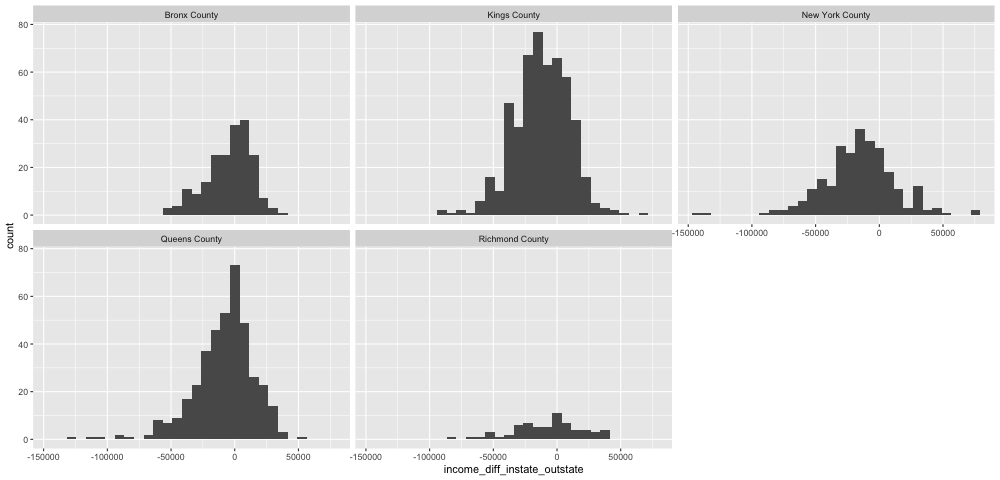

In [11]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=income_diff_instate_outstate) +
    geom_histogram() + 
    facet_wrap(~borough) 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 882 rows containing non-finite values (`stat_bin()`). 



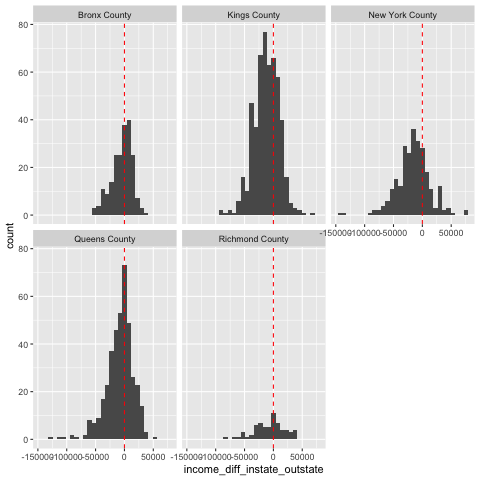

In [12]:
%%R 
ggplot(nyc_census_data) + 
aes(x=income_diff_instate_outstate) +
geom_histogram() + 
    geom_vline(xintercept = 0, color="red", linetype="dashed") +
    facet_wrap(~borough)


#histograms show the frequency of something (distributions)
#in this case, the y-axis shows the frequency of the neighborhoods in each borough where out-of-staters are making more than in-staters
#the y-axis is showing the amount of money they're making?


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 882 rows containing non-finite values (`stat_bin()`). 



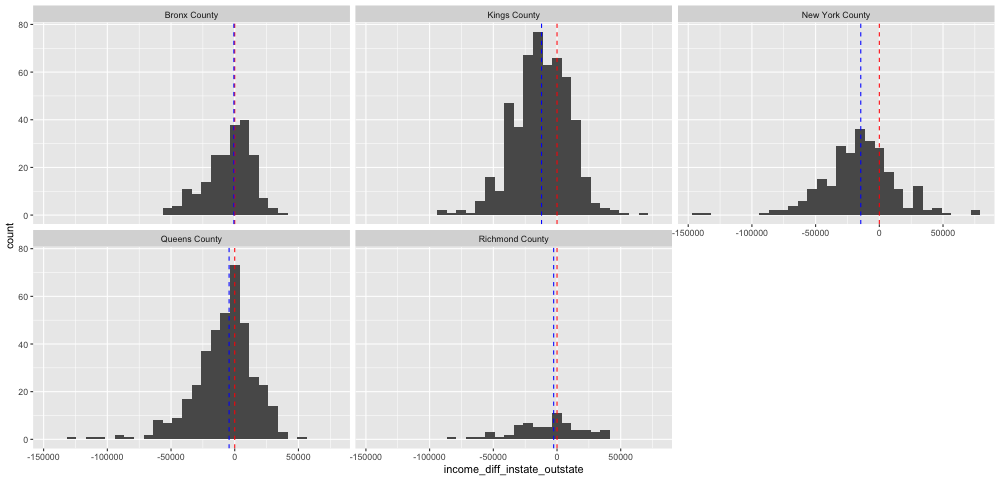

In [16]:
%%R -w 1000
library(dplyr)
library(ggplot2)

# Calculate median income difference for each borough
borough_medians <- nyc_census_data %>%
  group_by(borough) %>%
  summarize(median_income_diff = median(income_diff_instate_outstate, na.rm = TRUE))

# Create the histogram and add median lines for each borough
ggplot(nyc_census_data) + 
  aes(x=income_diff_instate_outstate) +
  geom_histogram() + 
  geom_vline(xintercept = 0, color="red", linetype="dashed") +
  geom_vline(data = borough_medians, aes(xintercept = median_income_diff), color="blue", linetype="dashed") +
  facet_wrap(~borough)

#the blue line shows the median but not sure what median that is? the median of those neighborhoods?
#what does it mean when in certain instances those lines are so close together whereas, in some other instances, they're further apart?
#The blue lines represent the median income difference within each borough. 
#The median is the middle value when you order all the income differences from lowest to highest.
#It is not the average but the midpoint of the data.

#When the blue median lines are close to the red line (xintercept = 0),
#it means the median income difference between instate and outstate residents within that borough is small. 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 882 rows containing non-finite values (`stat_boxplot()`). 

R[write to console]: 2: Removed 882 rows containing missing values (`geom_point()`). 



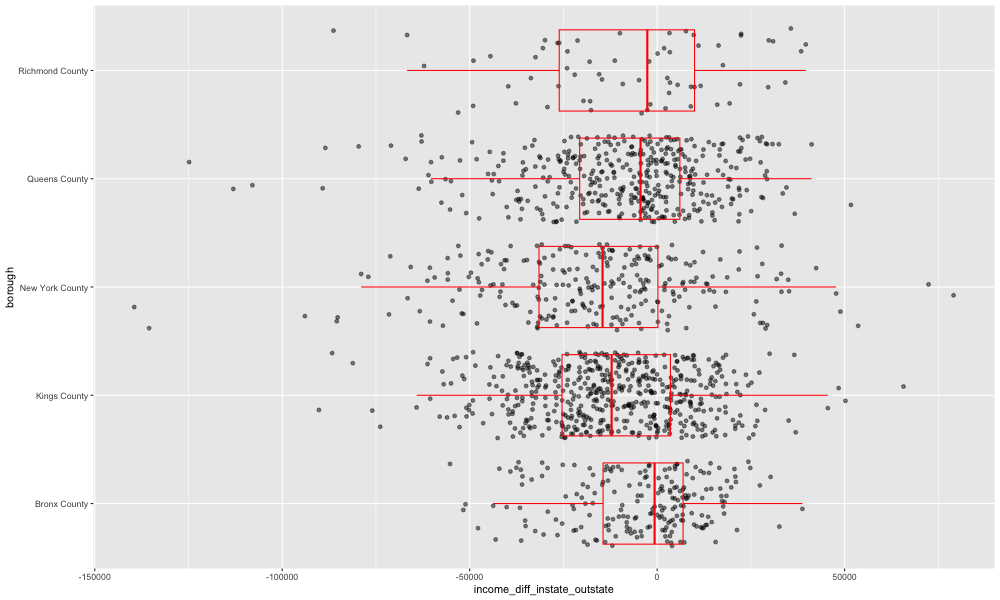

In [17]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=income_diff_instate_outstate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 


#scatterplots make it a little bit easier to understand distributions
#the red line in the middle is basically the blue line aka it shows the median. 
#A red line (indicating the median income difference) closer to zero 
#suggests that the median gap in income between instate and outstate residents is small. 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

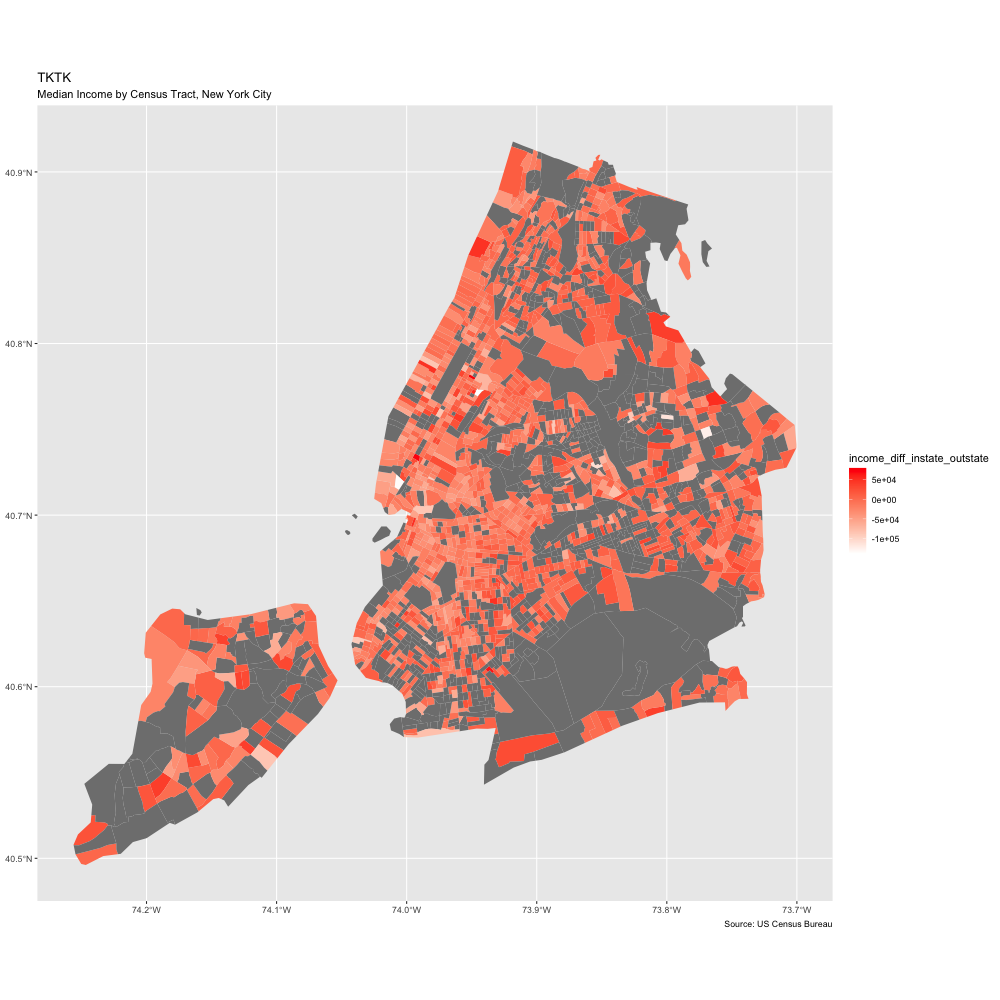

In [18]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = income_diff_instate_outstate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "TKTK",
    subtitle = "Median Income by Census Tract, New York City",
    caption = "Source: US Census Bureau"
  )


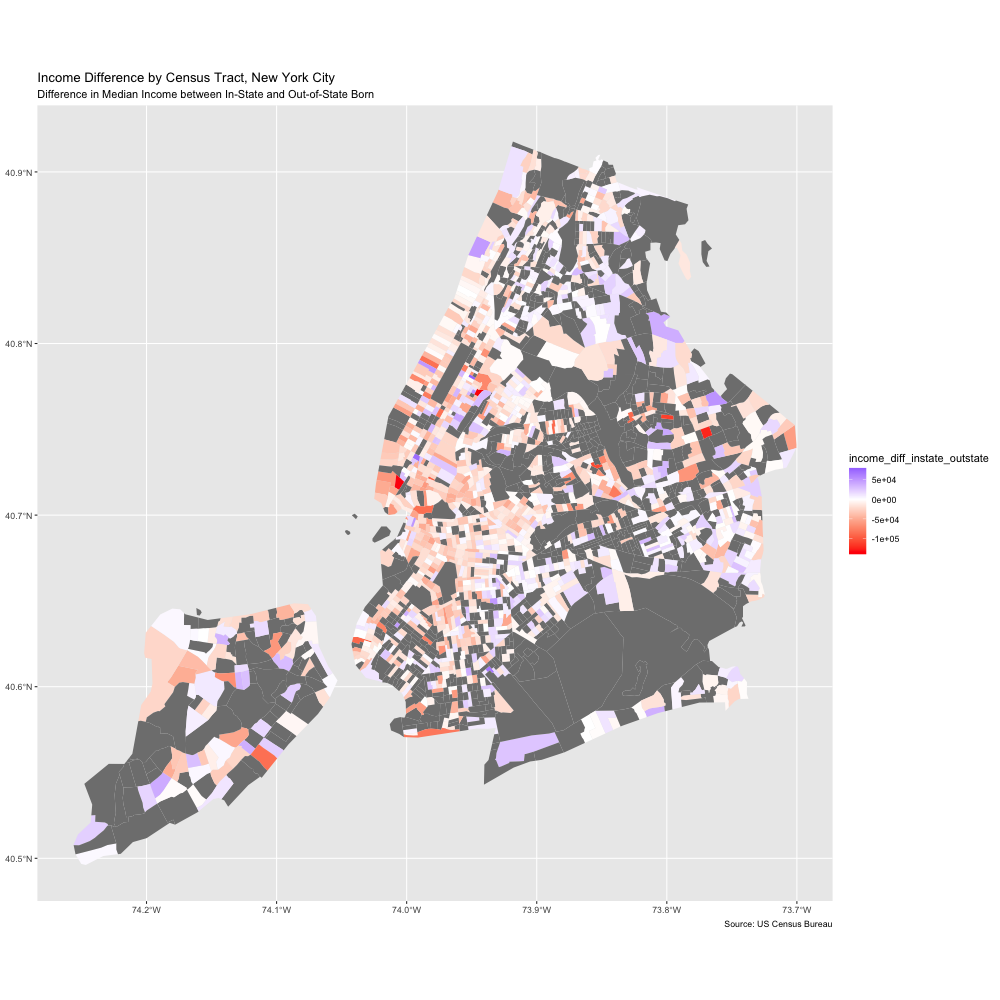

In [20]:
%%R -w 1000 -h 1000
nyc_census_data %>%
  ggplot(aes(fill = income_diff_instate_outstate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient2(low="red", mid="white", high="blue", midpoint=0) + 
  labs(
    title = "Income Difference by Census Tract, New York City",
    subtitle = "Difference in Median Income between In-State and Out-of-State Born",
    caption = "Source: US Census Bureau"
  )

In [ ]:
#title: "The Economic Divide in NYC Neighborhoods: Income Differences between people born in-state vs those born out-of-state"
#subtitle: "The map displays NYC's neighborhood-level disparities. In particular, it shows that in New York County and Kings County 
#there are more neighborhoods where people born out of state are earning more than those born in state. 
"Map of New York City displaying neighborhood-level income disparities, highlighting areas where out-of-state residents have higher incomes than in-state residents,
with a detailed focus on disparities within New York County and Kings County."

# Step 7 | Your Turn

- 👉 Here are the various [geographies you can use with tidycensus](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus). Try changing the analysis from the census tract level to the something more granular like `block group`. What do you notice that you didn't when looking at the tract-level data?

- 👉 Pick a different variable other than median income and re-run the notebook. Use [https://censusreporter.org/](https://censusreporter.org) figure out what variable or variables you'd like to explore and add them to the list in **step 2**. 

    *hint*: Remember, you can create new columns in **step 5** using `mutate`. For example, the following code would both split the borough out of the NAME column, and also 

    ```r
    nyc_census_data <- nyc_census_data %>% 
        mutate(
            borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
            units_per_person = total_unitstotal_units_estimate / population_estimate
        ) 

    nyc_census_data
    ```